#### Import libs

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from DCGAN import Generator, Discriminator, init_model
from torch.utils.tensorboard import SummaryWriter

#### Define device

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

#### Define hyperparameters

In [3]:
Z_DIM = 100
IMAGE_CHANNELS = 1
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
NUM_EPOCHS = 5
FEATURES_GENERATOR = 64
FEATURES_DISCRIMINATOR = 64


#### Use transforms

In [4]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(IMAGE_CHANNELS)], 
                         [0.5 for _ in range(IMAGE_CHANNELS)])
])

#### Load data and send it to dataloader

In [5]:
data = torchvision.datasets.MNIST(root='./datasets/', download=True, transform=transform)

In [6]:
loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

#### Init model and defint optimizers

In [7]:
gen = Generator(Z_DIM, IMAGE_CHANNELS, FEATURES_GENERATOR).to(device)
dis = Discriminator(IMAGE_CHANNELS, FEATURES_DISCRIMINATOR).to(device)

init_model(gen)
init_model(dis)

In [8]:
optimizer_generator = torch.optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(dis.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))

loss_fn = torch.nn.BCELoss()
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_fake = SummaryWriter('./runs/DCGAN/fake')
writer_real = SummaryWriter('./runs/DCGAN/real')

#### Send it on train mode

In [9]:
gen.train()
dis.train()

Discriminator(
  (dis): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2)

#### Define train loop

In [10]:
step = 0

In [11]:
for epoch in tqdm(range(NUM_EPOCHS)):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device) 
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        # Train Discriminator
        disc_real = dis(real).reshape(-1)
        loss_disc_real = loss_fn(disc_real, torch.ones_like(disc_real))
        disc_fake = dis(fake.detach()).reshape(-1)
        loss_dics_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))
        loss_dis = (loss_disc_real + loss_dics_fake) / 2
        optimizer_discriminator.zero_grad()
        loss_dis.backward()
        optimizer_discriminator.step()

        # Train Generator 
        out = dis(fake).reshape(-1)
        loss_gen = loss_fn(out, torch.ones_like(out))
        optimizer_generator.zero_grad()
        loss_gen.backward()
        optimizer_generator.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch [{batch_idx}/{len(loader)}] \
                    Loss D: {loss_dis:.4f}, Loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image('Real', img_grid_real, global_step=step)
                writer_fake.add_image('Fake', img_grid_fake, global_step=step)
            step += 1

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [0/5] Batch [0/469]                     Loss D: 0.6931, Loss G: 0.7788
Epoch [0/5] Batch [100/469]                     Loss D: 0.0577, Loss G: 2.9886
Epoch [0/5] Batch [200/469]                     Loss D: 0.6821, Loss G: 0.7398
Epoch [0/5] Batch [300/469]                     Loss D: 0.3820, Loss G: 0.4603
Epoch [0/5] Batch [400/469]                     Loss D: 0.6037, Loss G: 1.2618
Epoch [1/5] Batch [0/469]                     Loss D: 0.6239, Loss G: 1.1151
Epoch [1/5] Batch [100/469]                     Loss D: 0.6205, Loss G: 0.8654
Epoch [1/5] Batch [200/469]                     Loss D: 0.6734, Loss G: 1.6488
Epoch [1/5] Batch [300/469]                     Loss D: 0.6182, Loss G: 0.6289
Epoch [1/5] Batch [400/469]                     Loss D: 0.7415, Loss G: 1.4284
Epoch [2/5] Batch [0/469]                     Loss D: 0.5756, Loss G: 0.8093
Epoch [2/5] Batch [100/469]                     Loss D: 0.5680, Loss G: 0.5794
Epoch [2/5] Batch [200/469]                     Loss D: 0.

#### Check results

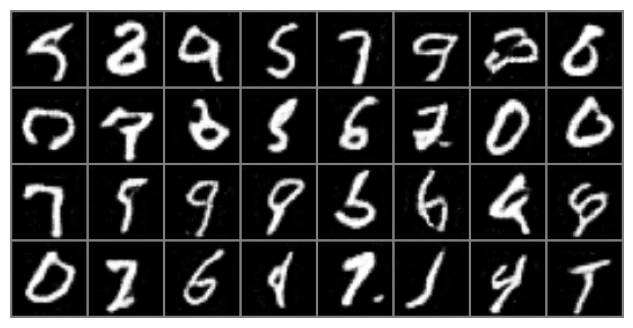

In [12]:
fake_imgs = gen(fixed_noise)

fake_imgs = torchvision.utils.make_grid(fake_imgs)[0].detach().cpu()
plt.figure(figsize=(14, 4))
plt.imshow(fake_imgs, cmap='gray')
plt.axis("off")
plt.show()